<a href="https://colab.research.google.com/github/andres-merino/AprendizajeAutomaticoInicial-05-N0105/blob/main/2-Ejercicios/04-Agrupamiento-kMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="border: none; border-collapse: collapse;">
    <tr>
        <td style="width: 20%; vertical-align: middle; padding-right: 10px;">
            <img src="https://i.imgur.com/nt7hloA.png" width="100">
        </td>
        <td style="width: 2px; text-align: center;">
            <font color="#0030A1" size="7">|</font><br>
            <font color="#0030A1" size="7">|</font>
        </td>
        <td>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="5">
                <b>Facultad de Ciencias Exactas, Naturales y Ambientales</b>
            </font> </p>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="4">
                Aprendizaje Automático Inicial &bull; Agrupamiento k-Means
            </font></p>
            <p style="font-style: oblique;"><font color="#0030A1" size="3">
                Emilio Andrade &bull; 2025-12-15
            </font></p>
        </td>  
    </tr>
</table>

---
## <font color='264CC7'> Introducción </font>

A lo largo de este taller, aplicaremos el algoritmo de agrupamiento jerárquico a un conjunto de datos.

Los paquetes necesarios son:

In [1]:
# Paquetes necesarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score


---
## <font color='264CC7'> Preprocesamiento de datos </font>

Primero necesitas el conjunto de datos. Los datos a utilzar son los seleccionados en la clase aterior.

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Carga el conjunto de datos y procésalos:
<ul>
  <li>Muestra algunos datos.</li>
  <li>Muestra una descripción de los datos.</li>
  <li>Escala los datos si es necesario.</li>
</ul>
</div>

In [3]:
# Leer los datos
data = pd.read_csv("https://raw.githubusercontent.com/andres-merino/AprendizajeAutomaticoInicial-05-N0105/refs/heads/main/2-Notebooks/datos/Pokemon.csv")

display(data.head())
data.describe(include="all")
# Columnas numéricas para k-means
numeric_cols = ["Attack", "Defense", "Speed", "Sp. Atk", "Sp. Def", "HP"]
data = data[["Name", *numeric_cols]]

display(data.head())
# Escalar datos
scaler = StandardScaler()
X = scaler.fit_transform(data[numeric_cols])


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Stage,Remaining_Evolutions,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,2,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,2,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,3,0,False
3,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,2,False
4,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,2,1,False


,Name,Attack,Defense,Speed,Sp. Atk,Sp. Def,HP
0,Bulbasaur,49,49,45,65,65,45
1,Ivysaur,62,63,60,80,80,60
2,Venusaur,82,83,80,100,100,80
3,Charmander,52,43,65,60,50,39
4,Charmeleon,64,58,80,80,65,58


---
## <font color='264CC7'> Determinación del número de clusters </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Determina el número óptimo de clústeres para un modelo K-Means utilizando el método del codo.
<ul>
  <li>Genera una gráfica que muestre la inercia frente al número de clústeres (k) en el rango de 1 a 10.</li>
  <li>Identifica visualmente el "codo" en la curva para seleccionar el número óptimo de clústeres.</li>
  <li>De manera intuitiva, explica por qué consideras ese punto como el codo y cómo influye en la calidad de los clústeres.</li>
</ul>
</div>


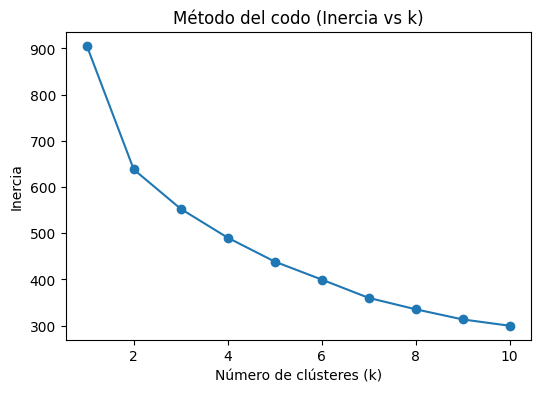

In [6]:
# Método del codo, con más init para aplanar
inertia = []
for i in range(1, 11):
    modelo = KMeans(n_clusters=i, random_state=42, n_init=50)
    modelo.fit(X)
    inertia.append(modelo.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), inertia, marker="o")
plt.title("Método del codo (Inercia vs k)")
plt.xlabel("Número de clústeres (k)")
plt.ylabel("Inercia")
plt.show()


**Selección de k (método del codo):**  
Visualmente, el “codo” se observa alrededor de **k = 4**, porque hasta ese punto la inercia disminuye de forma marcada y, a partir de ahí, la curva se vuelve más plana.

**Interpretación intuitiva:**  
Antes del codo, aumentar k mejora bastante la compactación de los grupos (los puntos quedan más cerca de su centro). Después del codo, agregar más clústeres reduce la inercia solo un poco, por lo que se empiezan a dividir grupos sin una mejora clara en la calidad.

**Sobre la inicialización (`n_init`):**  
Se aumentó `n_init` para probar varias inicializaciones del algoritmo y quedarse con la de menor inercia. Esto hace la curva más estable y evita “subidas” pequeñas causadas por soluciones locales.


---
## <font color='264CC7'> Asignación de grupos y análisis </font>


<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Realiza un análisis de los grupos obtenidos.
<ul>
  <li>Asigna los grupos.</li>
  <li>Revisa la media de cada grupo.</li>
  <li>Revisa el mínimo y máximo de cada grupo.</li>
  <li>Muestra algunos integrantes de cada grupo.</li>
</ul>
</div>

In [7]:
# Asignación y análisis de grupos
k_opt = 4
modelo = KMeans(n_clusters=k_opt, random_state=42, n_init=50)
modelo.fit(X)
labels = modelo.labels_

data["Cluster"] = ["C" + str(c) for c in labels]
data["Cluster"].value_counts()

data.groupby("Cluster")[numeric_cols].mean()
data.groupby("Cluster")[numeric_cols].min()
data.groupby("Cluster")[numeric_cols].max()

for cluster in data["Cluster"].unique():
    print(f"Cluster {cluster}: cantidad {data[data['Cluster']==cluster].shape[0]}")
    display(data[data["Cluster"] == cluster].head(5))


Cluster C2: cantidad 56


,Name,Attack,Defense,Speed,Sp. Atk,Sp. Def,HP,Cluster
0,Bulbasaur,49,49,45,65,65,45,C2
3,Charmander,52,43,65,60,50,39,C2
6,Squirtle,48,65,43,50,64,44,C2
9,Caterpie,30,35,45,20,20,45,C2
10,Metapod,20,55,30,25,25,50,C2


Cluster C1: cantidad 40


,Name,Attack,Defense,Speed,Sp. Atk,Sp. Def,HP,Cluster
1,Ivysaur,62,63,60,80,80,60,C1
4,Charmeleon,64,58,80,80,65,58,C1
5,Charizard,84,78,100,109,85,78,C1
7,Wartortle,63,80,58,65,80,59,C1
11,Butterfree,45,50,70,90,80,60,C1


Cluster C3: cantidad 31


,Name,Attack,Defense,Speed,Sp. Atk,Sp. Def,HP,Cluster
2,Venusaur,82,83,80,100,100,80,C3
8,Blastoise,83,100,78,85,105,79,C3
30,Nidoqueen,92,87,76,75,85,90,C3
33,Nidoking,102,77,85,85,75,81,C3
35,Clefable,70,73,60,95,90,95,C3


Cluster C0: cantidad 24


,Name,Attack,Defense,Speed,Sp. Atk,Sp. Def,HP,Cluster
26,Sandshrew,75,85,40,20,30,50,C0
27,Sandslash,100,110,65,45,55,75,C0
46,Parasect,95,80,30,60,80,60,C0
66,Machoke,100,70,45,50,60,80,C0
73,Geodude,80,100,20,30,30,40,C0


<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Da una descripción de los grupos obtenidos. Asigna un nombre a cada grupo.
</div>

**Análisis general de los clústeres (k = 4):**  
- **C2 (56)**: Pokémon con **stats bajos** en general (ej.: Bulbasaur, Charmander, Squirtle, Caterpie). Se ven perfiles “básicos” o de etapas tempranas.  
- **C1 (40)**: Pokémon con **stats medios** y más equilibrados (ej.: Ivysaur, Charmeleon, Wartortle, Butterfree). En general, un nivel intermedio.  
- **C3 (31)**: Pokémon con **stats altos** (ej.: Venusaur, Blastoise, Nidoking/Nidoqueen), típicamente más fuertes o más completos.  
- **C0 (24)**: Pokémon con perfil más **físico/defensivo** (ej.: Sandshrew/Sandslash, Geodude), donde se percibe **defensa alta** y **velocidad baja** en varios casos.


---
## <font color='264CC7'> Visualizaciones  </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Realiza una visualización de los grupos obtenidos en 2D seleccionando dos variables que creas relevantes.
<ul>
  <li>¿Qué tan buenos te parecen los grupos?</li>
</ul>
</div>

In [8]:
# Visualización 2D
var1, var2 = "Attack", "Sp. Atk"
fig = px.scatter(
    data,
    x=var1, y=var2,
    color="Cluster",
    hover_data=["Name"],
    title=f"Clusters en 2D ({var1} vs {var2})"
)
fig.update_traces(marker=dict(opacity=0.75))
fig.show()


**¿Qué tan buenos me parecen los grupos?**  
En el plano 2D (Attack vs Sp. Atk) los clústeres se ven **razonables**, porque hay una separación general entre Pokémon con valores **bajos** y **altos**, y también se nota una tendencia de perfiles más **físicos** vs más **especiales**. Sin embargo, existe **solapamiento** en la zona media (especialmente entre algunos clústeres), lo cual es normal porque el modelo se construyó con **6 variables** y aquí solo se visualizan **2**. Por eso, la calidad final se confirma mejor con métricas como la **silueta**.


<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Realiza una visualización de los grupos obtenidos en 2D usando reducción de dimensionalidad diferente a PCA.
<ul>
  <li>¿Qué tan buenos te parecen los grupos?</li>
  <li>Indica el porcentaje de la variaza explicada en el gráfico, ¿afecta esto a tu visualización?</li>
</ul>
</div>

In [9]:
# Reducción 2D (no PCA) + % varianza explicada
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X)
var_exp = svd.explained_variance_ratio_.sum() * 100

df_2d = pd.DataFrame(X_2d, columns=["C1", "C2"])
df_2d["Name"] = data["Name"].values
df_2d["Cluster"] = data["Cluster"].values

fig = px.scatter(
    df_2d,
    x="C1", y="C2",
    color="Cluster",
    hover_data=["Name"],
    title=f"Clusters en 2D (SVD) | Varianza explicada: {var_exp:.2f}%"
)
fig.update_traces(marker=dict(opacity=0.75))
fig.show()


**¿Qué tan buenos me parecen los grupos?**  
En la proyección 2D con SVD los clústeres se ven **más claros** que con dos variables directas: **C2** queda bien separado hacia la izquierda y **C3** se concentra más hacia la derecha. Aun así, existe **solapamiento** (sobre todo entre **C1 y C3** en la zona central), por lo que la separación no es perfecta.

**Varianza explicada y efecto:**  
La varianza explicada en el gráfico es **61.32%**. Sí afecta: como la proyección conserva una parte importante de la información, la visualización es **bastante representativa**, pero el **38.68% restante** no se ve en 2D y puede explicar parte del solapamiento entre grupos.


---
## <font color='264CC7'> Métricas  </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
Calcula la métrica de la silueta para los grupos obtenidos. ¿Qué tan buenos te parecen los grupos?
</div>

In [10]:
# Silueta
score = silhouette_score(X, labels)
score


np.float64(0.21823464505101614)

**¿Qué tan buenos son los grupos según la silueta?**  
La silueta obtenida es **0.218**. Esto indica que los clústeres son **aceptables pero débiles**: existe cierta estructura, pero hay **bastante solapamiento** entre grupos.
